# Inference with sampling for flu data

## Flu case incidences

In [1]:
import numpy as np
import pandas as pd

import seirmo as se
from seirmo import plots

# read french flu data
flu_data = se.DatasetLibrary().french_flu()

# extract data of roughly one season (estimated)
flu_data = flu_data.loc[:30,:]
times = flu_data['time_index']

# normalise incidence number by its maximum
flu_data['inc'] = flu_data['inc'] / np.max(flu_data['inc'])

In [2]:
# Plot incidences data
plot = plots.IncidenceNumberPlot()
plot.add_data(flu_data, time_key='time_index', inc_key='inc')
plot.show()

# Using pints

In [3]:
import pints

class SEIRModel(pints.ForwardModel):
    def __init__(self):
        super(SEIRModel, self).__init__()

        self._model = se.SEIRModel()
    
    def n_outputs(self):
        # Returns number of model outputs.
        # Returns only incidence number, in line with the flu data
        return 1

    def n_parameters(self):
        # Returns number of parameters, i.e. 4 initial condition and 3 parameters.
        return 5
    
    def simulate(self, parameters, times):
        # fixing 2 parameters as it is not identifiable
        parameters = np.insert(parameters, 3, 0.5)
        parameters = np.insert(parameters, 6, 0.1)
        output = self._model.simulate(parameters=parameters, times=times, return_incidence=True)
        n_incidence = output[:,4]

        return n_incidence

In [4]:
# Create log-likelihood
pints_model = SEIRModel()
problem = pints.SingleOutputProblem(pints_model, times, flu_data['inc'])
log_likelihood = pints.GaussianLogLikelihood(problem)

In [5]:
# Create prior distribution
log_prior = pints.ComposedLogPrior(
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf),
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
)


In [6]:
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Starting point for the MCMC algorithm is taken as the value obtained from optimisation.

In [7]:
# Initial guess from optmised values
xs = np.array([[7.89611086e+00, 3.24897251e-04, 1.00010396e-05, 6.74609239e-01, 1.91843423e-01, 0.01]])

In [8]:
# Parameter transformation
transform = pints.LogTransformation(n_parameters=6)
mcmc = pints.MCMCController(log_posterior, 3, [xs[0], xs[0], xs[0]], method=pints.HaarioBardenetACMC, transform=transform)

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0         0          0:00.1
2     9      0         0         0.333      0:00.2
3     12     0         0         0.25       0:00.3
20    63     0.0476    0.19      0.238      0:01.0
40    123    0.122     0.171     0.22       0:01.8
60    183    0.0984    0.213     0.213      0:03.0
80    243    0.111     0.198     0.185      0:04.1
100   303    0.109     0.188     0.149      0:05.2
120   363    0.124     0.223     0.14       0:06.4
140   423    0.106383  0.212766  0.121      0:07.9
160   483    0.0994    0.199     0.124      0:09.2
180   543    0.0939    0.188     0.116      0:10.3
Initial phase completed.
200   603    0.0846    0.194     0.129      0:11.2
220   663    0.127     0.222     0.167      0:11.9
240   723    0.174     0.241     0.212      0:12.5
260   783   

3100  9303   0.197     0.204     0.195      1:17.6
3120  9363   0.197693  0.204     0.195      1:18.0
3140  9423   0.197071  0.203     0.197      1:18.4
3160  9483   0.197     0.202     0.197      1:18.8
3180  9543   0.198     0.204     0.197      1:19.1
3200  9603   0.198     0.204     0.198      1:19.6
3220  9663   0.198     0.204     0.197      1:19.9
3240  9723   0.198087  0.204875  0.197      1:20.3
3260  9783   0.197     0.205     0.198      1:20.7
3280  9843   0.198     0.205     0.198      1:21.1
3300  9903   0.198     0.205     0.199      1:21.6
3320  9963   0.197     0.204     0.199      1:21.9
3340  10023  0.196947  0.204     0.198      1:22.3
3360  10083  0.197     0.204     0.199      1:22.8
3380  10143  0.197     0.204     0.2        1:23.2
3400  10203  0.198     0.205     0.2        1:23.7
3420  10263  0.197     0.206     0.2        1:24.2
3440  10323  0.198     0.206     0.201      1:24.7
3460  10383  0.198     0.207     0.200809   1:25.2
3480  10443  0.199     0.206   

6320  18963  0.204     0.216     0.212      2:27.2
6340  19023  0.204     0.216     0.212      2:27.6
6360  19083  0.204     0.215     0.212      2:28.1
6380  19143  0.204     0.215     0.211879   2:28.5
6400  19203  0.204     0.214     0.211      2:28.8
6420  19263  0.204     0.214     0.211      2:29.3
6440  19323  0.204     0.214     0.211      2:29.7
6460  19383  0.204     0.213     0.211      2:30.1
6480  19443  0.204     0.213     0.212      2:30.4
6500  19503  0.204     0.213     0.212275   2:30.8
6520  19563  0.203     0.213     0.212      2:31.2
6540  19623  0.204     0.213     0.212      2:31.6
6560  19683  0.204     0.213     0.212      2:32.0
6580  19743  0.204     0.213     0.212      2:32.5
6600  19803  0.205     0.212695  0.212      2:33.0
6620  19863  0.204     0.213     0.211      2:33.4
6640  19923  0.204     0.214     0.211      2:33.8
6660  19983  0.203     0.214     0.212      2:34.2
6680  20043  0.204     0.214     0.211      2:34.6
6700  20103  0.204     0.215   

9540  28623  0.213     0.212     0.21       3:40.2
9560  28683  0.213     0.212     0.21       3:40.8
9580  28743  0.213     0.212     0.21       3:41.5
9600  28803  0.214     0.212     0.209874   3:42.2
9620  28863  0.213     0.212348  0.21       3:42.9
9640  28923  0.213     0.213     0.21       3:43.6
9660  28983  0.214     0.213     0.211      3:44.3
9680  29043  0.214     0.213     0.211      3:44.9
9700  29103  0.214     0.213     0.211      3:45.6
9720  29163  0.214     0.213     0.211      3:46.2
9740  29223  0.214     0.213     0.211      3:46.8
9760  29283  0.214     0.213     0.211      3:47.5
9780  29343  0.214     0.213     0.212      3:48.1
9800  29403  0.214     0.213     0.212      3:48.8
9820  29463  0.214     0.213     0.212      3:49.5
9840  29523  0.214714  0.214     0.212      3:50.2
9860  29583  0.215394  0.214     0.213      3:50.7
9880  29643  0.216     0.215     0.213      3:51.5
9900  29703  0.216     0.215     0.213      3:52.1
9920  29763  0.216     0.215   

# Pints' diagnostic plots

Checking the trace of the sampling algorithm

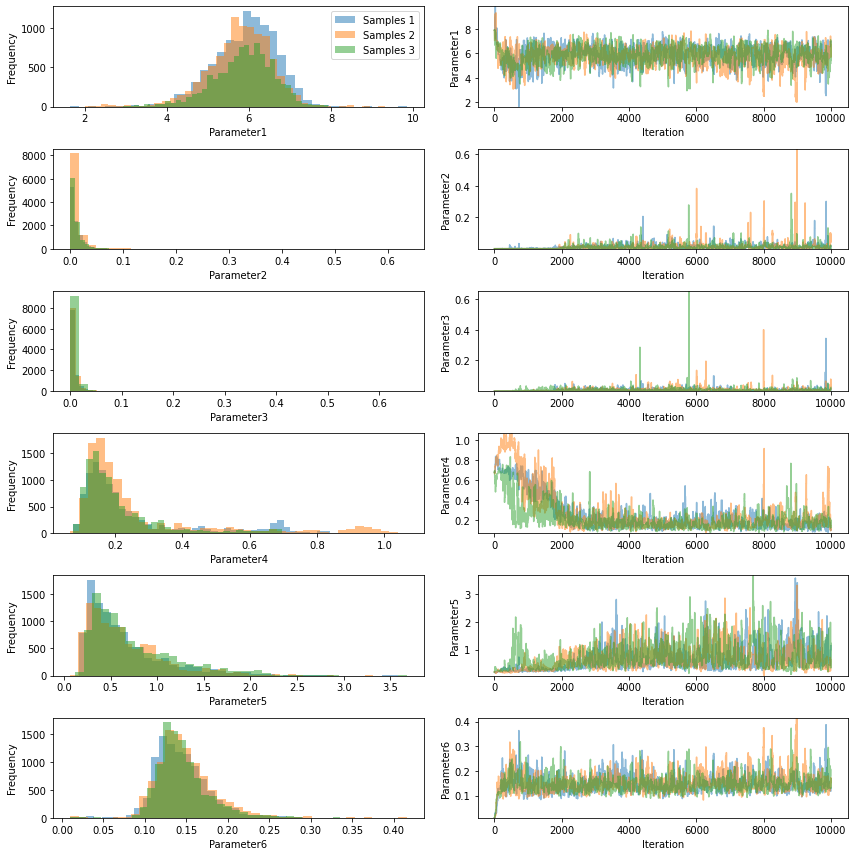

In [9]:
import pints.plot
import matplotlib.pyplot as plt

pints.plot.trace(chains)
plt.show()

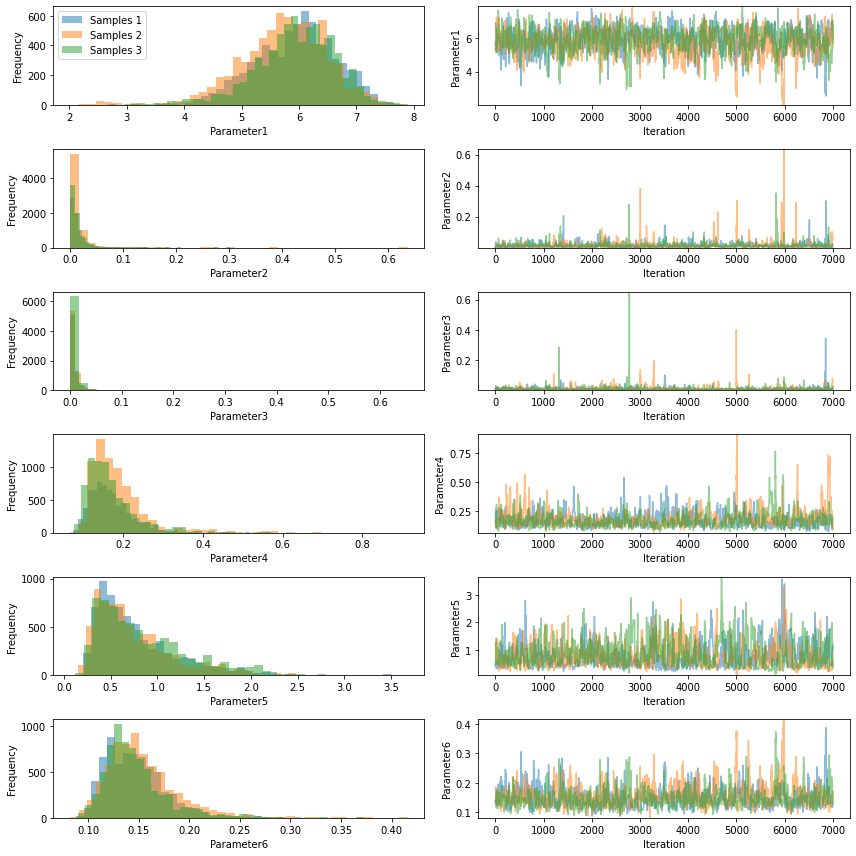

In [10]:
pints.plot.trace(chains[:, 3000:, :])
plt.show()

# Posterior predictive plot

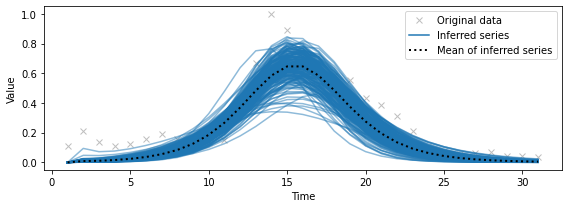

In [11]:
pints.plot.series(chains[0, 3000:], problem)
plt.show()

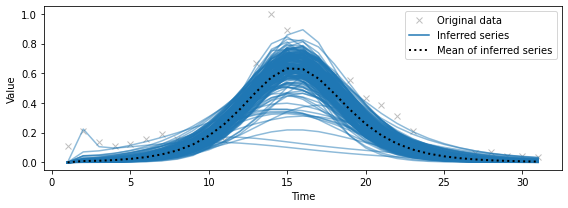

In [12]:
pints.plot.series(chains[1, 3000:], problem)
plt.show()

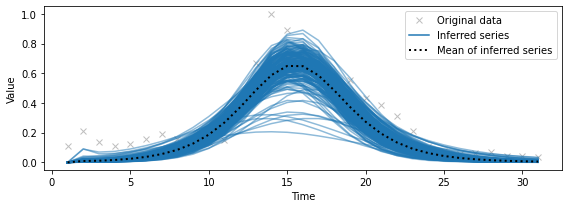

In [13]:
pints.plot.series(chains[2, 3000:], problem)
plt.show()